# COGS 108 - EDA Checkpoint

# Names

* Arnav Tayal
* Chaewon Heo
* Martha Chow
* Zhiyi Zhu

<a id='research_question'></a>
# Research Question

Main question: Are characteristics of an individual’s diet (such as the amount of calories, macronutrients, and/or micronutrients) correlated with their likelihood of contracting COVID-19?

Sub-questions: Can we correlate diet type (eg. vegetarian, keto, pescetarian) with an individual’s likelihood of contracting COVID-19? Which characteristic is the strongest predictor?

Potential extension: Does correlation between a characteristic necessarily mean causation (eg. If we find that there is a positive correlation between kcal/day and likelihood of contracting COVID-19, does that necessarily mean that a high calorie diet leads to higher vulnerability to COVID-19?)? How much literature is there on databases to support the causal relationship?

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# packages for importing files
import os
import glob

__Get the add the Confirmed,Deaths,Recovered,Active,Population to the dataframe; those are directly extracted from the dataframe that records the precentages. Beside the population, the unit for the other 4 quantitative columns are in percentages.__



In [2]:
df_covid = pd.read_csv('Food_Supply_Quantity_kg_Data.csv',usecols=['Country','Confirmed','Deaths','Recovered','Active','Population'])
df_covid.columns = (map(lambda x: x.lower(), df_covid.columns))
df_covid.head(3)

,country,confirmed,deaths,recovered,active,population
0,Afghanistan,0.142134,0.006186,0.123374,0.012574,38928000.0
1,Albania,2.967301,0.050951,1.792636,1.123714,2838000.0
2,Algeria,0.244897,0.006558,0.167572,0.070767,44357000.0


# Data Cleaning

__Process data for food quantity (unit: kg/capita/yr)__

In [3]:
# read in most csvs as a list
path = 'Food_Supply_Quantity_Kg'
all_files = glob.glob(os.path.join(path, "*.csv"))

In [4]:
# function that standardize food name; all lowercase + no space + no special character
def getName(n):
    name = n.replace(' ','_')
    name = name.replace('-','')
    name = name.replace(',','')
    name = name.replace('&','')
    name = name.replace('__','_')
    return name.lower()

In [5]:
# read in the first csv in the directory so we can merge other csvs with it
col_list = ["Area", "Item", "Value"] # we only need the country and the quantity of food from the file
df_quantity = pd.read_csv(all_files[0], usecols=col_list)
name = getName(df_quantity.loc[0].at["Item"])
df_quantity = df_quantity.drop('Item', 1)
df_quantity.columns = ['country',name]

# merge all csvs in the directory into df_quantity
for i in all_files[1:len(all_files)]:
    # extract the name of the file
    tmp = pd.read_csv(i, usecols=col_list)
    name = getName(tmp.loc[0].at["Item"])
    tmp = tmp.drop('Item', 1)
    tmp.columns = ['country',name] 
    df_quantity = pd.merge(df_quantity,tmp,on ='country', how='outer')

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6756\1764355593.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_quantity = df_quantity.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6756\1764355593.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6756\1764355593.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6756\1764355593.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\Publ

In [6]:
# we also need the Animal Product and Vegetal Product csvs that are in different forms, so add them to dataframe seperately
animal = pd.read_csv('FAOSTAT_food_kg_animal.csv')
animal.columns = ['country','animal_products'] 
vegetal_prod = pd.read_csv('FAOSTAT_food_kg_vegetal_prod.csv')
vegetal_prod.columns = ['country','vegetal_products']
df_quantity = pd.merge(df_quantity,animal,on ='country', how='outer')
df_quantity = pd.merge(df_quantity,vegetal_prod,on ='country', how='outer')

animal

,country,animal_products
0,Afghanistan,67.42
1,Albania,473.16
2,Algeria,153.89
3,Angola,56.27
4,Antigua and Barbuda,210.99
...,...,...
168,Venezuela (Bolivarian Republic of),157.62
169,Viet Nam,122.38
170,Yemen,35.01
171,Zambia,42.86


In [7]:
# sort the columns, with country at the first column, and the food columns in alphabetical order
df_quantity = df_quantity.sort_index(axis=1)
first_column = df_quantity.pop('country')
df_quantity.insert(0, 'country', first_column)

# fill na with 0
df_quantity = df_quantity.fillna(0)

In [8]:
# combine with total quantity dataframe with the covid dataframe
# TODO: if we want the df_covid to be a seperate dataframe, just delete this cell.
df_quantity = pd.merge(df_quantity,df_covid,on ='country', how='right') # join on right since the covid rates are essential for further analysis, so we don't want NA 

In [9]:
df_quantity.head(6)

,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,sugar_sweeteners,treenuts,vegetable_oils,vegetables,vegetal_products,confirmed,deaths,recovered,active,population
0,Afghanistan,0.01,1.41,67.42,0.0,177.30,1.50,0.25,38.23,8.59,...,9.64,0.55,3.82,48.34,289.89,0.142134,0.006186,0.123374,0.012574,38928000.0
1,Albania,42.15,3.42,473.16,0.0,145.76,14.66,5.36,171.08,47.51,...,38.74,3.82,8.22,296.86,787.33,2.967301,0.050951,1.792636,1.123714,2838000.0
2,Algeria,4.33,0.45,153.89,0.0,218.56,8.43,3.86,101.92,18.06,...,29.30,1.84,16.47,186.08,644.82,0.244897,0.006558,0.167572,0.070767,44357000.0
3,Angola,66.33,0.64,56.27,0.0,104.01,0.67,20.22,68.52,23.49,...,21.12,0.07,7.38,26.31,514.68,0.061687,0.001461,0.056808,0.003419,32522000.0
4,Antigua and Barbuda,45.29,0.11,210.99,0.0,75.93,2.88,52.54,136.07,72.04,...,49.07,0.32,10.26,69.01,421.99,0.293878,0.007143,0.190816,0.095918,98000.0
5,Argentina,66.28,3.47,300.48,0.0,130.63,15.50,7.29,93.87,109.38,...,47.43,0.31,14.82,67.57,476.16,4.356147,0.108227,3.905192,0.342729,45377000.0


In [10]:
df_quantity.shape

(170, 29)

__Process data for fat ( original unit: g/capita/day; will be converted to kg/capita/year)__

In [11]:
# function that converts g/capita/day to kg/capita/yr 
# TODO: someone check if this is correct
def standUnit(x):
    # g -> kg: / 1000
    # day -> year: * 365
    return x / 1000 * 365

In [12]:
# read in most csvs as a list
path = 'Fat_Supply'
all_files = glob.glob(os.path.join(path, "*.csv"))

# read in the first csv in the directory so we can merge other csvs with it
col_list = ["Area", "Item", "Value"] # we only need the country and the quantity of food from the file
df_fat = pd.read_csv(all_files[0], usecols=col_list)
name = getName(df_fat.loc[0].at["Item"])
df_fat = df_fat.drop('Item', 1)
df_fat.columns = ['country',name]

# merge all csvs in the directory into df_fat
for i in all_files[1:len(all_files)]:
    # extract the name of the file
    tmp = pd.read_csv(i, usecols=col_list)
    name = getName(tmp.loc[0].at["Item"])
    tmp = tmp.drop('Item', 1)
    tmp.columns = ['country',name] 
    df_fat = pd.merge(df_fat,tmp,on ='country', how='outer')
    
# sort the columns, with country at the first column, and the food columns in alphabetical order
df_fat = df_fat.sort_index(axis=1)
first_column = df_fat.pop('country')
df_fat.insert(0, 'country', first_column)

# replace na with 0
df_fat = df_fat.fillna(0)
df_fat.head(3)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6756\2945578154.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_fat = df_fat.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6756\2945578154.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6756\2945578154.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6756\2945578154.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\Public\Documen

,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,pulses,spices,starchy_roots,stimulants,sugar_crops,sugar_sweeteners,treenuts,vegetable_oils,vegetables,vegetal_products
0,Afghanistan,0.0,3.81,13.25,0.0,4.92,0.42,0.02,0.26,3.75,...,0.12,0.17,0.03,0.06,0.0,0.0,0.46,10.46,0.22,17.37
1,Albania,0.0,8.04,75.29,0.0,6.29,3.87,0.34,1.51,20.57,...,0.27,0.00,0.12,1.24,0.0,0.0,2.16,21.75,1.53,42.35
2,Algeria,0.0,1.43,22.98,0.0,6.70,1.94,0.32,0.92,6.21,...,0.43,0.25,0.18,0.46,0.0,0.0,1.37,43.61,0.82,56.72


In [13]:
# convert g/capita/day to kg/capita/yr
df_fat[df_fat.columns[1:len(df_fat.columns)]] = df_fat[df_fat.columns[1:len(df_fat.columns)]].applymap(standUnit)
df_fat.head(3)

,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,pulses,spices,starchy_roots,stimulants,sugar_crops,sugar_sweeteners,treenuts,vegetable_oils,vegetables,vegetal_products
0,Afghanistan,0.0,1.39065,4.83625,0.0,1.79580,0.15330,0.0073,0.09490,1.36875,...,0.04380,0.06205,0.01095,0.0219,0.0,0.0,0.16790,3.81790,0.08030,6.34005
1,Albania,0.0,2.93460,27.48085,0.0,2.29585,1.41255,0.1241,0.55115,7.50805,...,0.09855,0.00000,0.04380,0.4526,0.0,0.0,0.78840,7.93875,0.55845,15.45775
2,Algeria,0.0,0.52195,8.38770,0.0,2.44550,0.70810,0.1168,0.33580,2.26665,...,0.15695,0.09125,0.06570,0.1679,0.0,0.0,0.50005,15.91765,0.29930,20.70280


In [14]:
df_fat = pd.merge(df_fat,df_covid,on ='country', how='right') # join on right since the covid rates are essential for further analysis, so we don't want NA in the covid rates column
df_fat.head(3)

,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,sugar_sweeteners,treenuts,vegetable_oils,vegetables,vegetal_products,confirmed,deaths,recovered,active,population
0,Afghanistan,0.0,1.39065,4.83625,0.0,1.79580,0.15330,0.0073,0.09490,1.36875,...,0.0,0.16790,3.81790,0.08030,6.34005,0.142134,0.006186,0.123374,0.012574,38928000.0
1,Albania,0.0,2.93460,27.48085,0.0,2.29585,1.41255,0.1241,0.55115,7.50805,...,0.0,0.78840,7.93875,0.55845,15.45775,2.967301,0.050951,1.792636,1.123714,2838000.0
2,Algeria,0.0,0.52195,8.38770,0.0,2.44550,0.70810,0.1168,0.33580,2.26665,...,0.0,0.50005,15.91765,0.29930,20.70280,0.244897,0.006558,0.167572,0.070767,44357000.0


__Process protein as fat__

In [15]:
# read in most csvs as a list
path = 'Protein_Supply'
all_files = glob.glob(os.path.join(path, "*.csv"))

# read in the first csv in the directory so we can merge other csvs with it
col_list = ["Area", "Item", "Value"] # we only need the country and the quantity of food from the file
df_protein = pd.read_csv(all_files[0], usecols=col_list)
name = getName(df_protein.loc[0].at["Item"])
df_protein = df_protein.drop('Item', 1)
df_protein.columns = ['country',name]

# merge all csvs in the directory into df_protein
for i in all_files[1:len(all_files)]:
    # extract the name of the file
    tmp = pd.read_csv(i, usecols=col_list)
    name = getName(tmp.loc[0].at["Item"])
    tmp = tmp.drop('Item', 1)
    tmp.columns = ['country',name] 
    df_protein = pd.merge(df_protein,tmp,on ='country', how='outer')
    
# sort the columns, with country at the first column, and the food columns in alphabetical order
df_protein = df_protein.sort_index(axis=1)
first_column = df_protein.pop('country')
df_protein.insert(0, 'country', first_column)

# replace na with 0
df_protein = df_protein.fillna(0)
df_protein.head(3)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6756\3721737032.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_protein = df_protein.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6756\3721737032.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6756\3721737032.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6756\3721737032.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\Public

,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,pulses,spices,starchy_roots,stimulants,sugar_crops,sugar_sweeteners,treenuts,vegetable_oils,vegetables,vegetal_products
0,Afghanistan,0.00,0.03,10.55,0.0,38.92,0.44,0.07,0.63,3.39,...,1.35,0.18,0.21,0.60,0.0,0.00,0.15,0.00,1.23,43.54
1,Albania,0.44,0.17,66.34,0.0,34.03,4.32,1.50,3.05,18.31,...,3.48,0.00,2.12,0.63,0.0,0.01,0.64,0.02,7.76,53.21
2,Algeria,0.06,0.01,25.71,0.0,49.36,2.40,1.18,2.16,6.52,...,4.74,0.33,2.72,0.86,0.0,0.00,0.51,0.05,5.81,67.21


In [16]:
# convert g/capita/day to kg/capita/yr
df_protein[df_protein.columns[1:len(df_protein.columns)]] = df_protein[df_protein.columns[1:len(df_protein.columns)]].applymap(standUnit)
df_protein.head(3)

,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,pulses,spices,starchy_roots,stimulants,sugar_crops,sugar_sweeteners,treenuts,vegetable_oils,vegetables,vegetal_products
0,Afghanistan,0.0000,0.01095,3.85075,0.0,14.20580,0.1606,0.02555,0.22995,1.23735,...,0.49275,0.06570,0.07665,0.21900,0.0,0.00000,0.05475,0.00000,0.44895,15.89210
1,Albania,0.1606,0.06205,24.21410,0.0,12.42095,1.5768,0.54750,1.11325,6.68315,...,1.27020,0.00000,0.77380,0.22995,0.0,0.00365,0.23360,0.00730,2.83240,19.42165
2,Algeria,0.0219,0.00365,9.38415,0.0,18.01640,0.8760,0.43070,0.78840,2.37980,...,1.73010,0.12045,0.99280,0.31390,0.0,0.00000,0.18615,0.01825,2.12065,24.53165


In [17]:
df_protein = pd.merge(df_protein,df_covid,on ='country', how='right') # join on right since the covid rates are essential for further analysis, so we don't want NA in the covid rates column
df_protein.head(3)

,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,sugar_sweeteners,treenuts,vegetable_oils,vegetables,vegetal_products,confirmed,deaths,recovered,active,population
0,Afghanistan,0.0000,0.01095,3.85075,0.0,14.20580,0.1606,0.02555,0.22995,1.23735,...,0.00000,0.05475,0.00000,0.44895,15.89210,0.142134,0.006186,0.123374,0.012574,38928000.0
1,Albania,0.1606,0.06205,24.21410,0.0,12.42095,1.5768,0.54750,1.11325,6.68315,...,0.00365,0.23360,0.00730,2.83240,19.42165,2.967301,0.050951,1.792636,1.123714,2838000.0
2,Algeria,0.0219,0.00365,9.38415,0.0,18.01640,0.8760,0.43070,0.78840,2.37980,...,0.00000,0.18615,0.01825,2.12065,24.53165,0.244897,0.006558,0.167572,0.070767,44357000.0


# Data Analysis & Results (EDA)

In [18]:
pip install patsy

Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import patsy
# packages for importing files
import os
import glob

## Creating Summary Dataframe ##

In [20]:
col_names = df_fat.columns

In [21]:
df_fat.head(3)

,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,sugar_sweeteners,treenuts,vegetable_oils,vegetables,vegetal_products,confirmed,deaths,recovered,active,population
0,Afghanistan,0.0,1.39065,4.83625,0.0,1.79580,0.15330,0.0073,0.09490,1.36875,...,0.0,0.16790,3.81790,0.08030,6.34005,0.142134,0.006186,0.123374,0.012574,38928000.0
1,Albania,0.0,2.93460,27.48085,0.0,2.29585,1.41255,0.1241,0.55115,7.50805,...,0.0,0.78840,7.93875,0.55845,15.45775,2.967301,0.050951,1.792636,1.123714,2838000.0
2,Algeria,0.0,0.52195,8.38770,0.0,2.44550,0.70810,0.1168,0.33580,2.26665,...,0.0,0.50005,15.91765,0.29930,20.70280,0.244897,0.006558,0.167572,0.070767,44357000.0


In [22]:
df_protein.head(3)

,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,sugar_sweeteners,treenuts,vegetable_oils,vegetables,vegetal_products,confirmed,deaths,recovered,active,population
0,Afghanistan,0.0000,0.01095,3.85075,0.0,14.20580,0.1606,0.02555,0.22995,1.23735,...,0.00000,0.05475,0.00000,0.44895,15.89210,0.142134,0.006186,0.123374,0.012574,38928000.0
1,Albania,0.1606,0.06205,24.21410,0.0,12.42095,1.5768,0.54750,1.11325,6.68315,...,0.00365,0.23360,0.00730,2.83240,19.42165,2.967301,0.050951,1.792636,1.123714,2838000.0
2,Algeria,0.0219,0.00365,9.38415,0.0,18.01640,0.8760,0.43070,0.78840,2.37980,...,0.00000,0.18615,0.01825,2.12065,24.53165,0.244897,0.006558,0.167572,0.070767,44357000.0


In [23]:
df_quantity.head(3)

,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,sugar_sweeteners,treenuts,vegetable_oils,vegetables,vegetal_products,confirmed,deaths,recovered,active,population
0,Afghanistan,0.01,1.41,67.42,0.0,177.30,1.50,0.25,38.23,8.59,...,9.64,0.55,3.82,48.34,289.89,0.142134,0.006186,0.123374,0.012574,38928000.0
1,Albania,42.15,3.42,473.16,0.0,145.76,14.66,5.36,171.08,47.51,...,38.74,3.82,8.22,296.86,787.33,2.967301,0.050951,1.792636,1.123714,2838000.0
2,Algeria,4.33,0.45,153.89,0.0,218.56,8.43,3.86,101.92,18.06,...,29.30,1.84,16.47,186.08,644.82,0.244897,0.006558,0.167572,0.070767,44357000.0


In [24]:
col_names

Index(['country', 'alcoholic_beverages', 'animal_fats', 'animal_products',
       'aquatic_products_other', 'cereals_excluding_beer', 'eggs',
       'fish_seafood', 'fruits_excluding_wine', 'meat',
       'milk_excluding_butter', 'miscellaneous', 'offals', 'oilcrops',
       'pulses', 'spices', 'starchy_roots', 'stimulants', 'sugar_crops',
       'sugar_sweeteners', 'treenuts', 'vegetable_oils', 'vegetables',
       'vegetal_products', 'confirmed', 'deaths', 'recovered', 'active',
       'population'],
      dtype='object')

In [25]:
country_names = list(df_fat['country'])
covid_names = ['confirmed', 'deaths', 'recovered', 'active',
       'population']
macronutrient_source_names = ['alcoholic_beverages', 'animal_fats',
       'animal_products', 'aquatic_products_other', 'cereals_excluding_beer',
       'eggs', 'fish_seafood', 'fruits_excluding_wine', 'meat',
       'milk_excluding_butter', 'miscellaneous', 'offals', 'oilcrops',
       'pulses', 'spices', 'starchy_roots', 'stimulants', 'sugar_crops',
       'sugar_sweeteners', 'treenuts', 'vegetable_oils', 'vegetables',
       'vegetal_products']

In [26]:
# yearly fat intake of first three countries (alphabetical) (unit: kg/capita/yr)
fat_sum = df_fat[macronutrient_source_names].sum(axis=1)
fat_sum.head(3)

0    22.34895
1    85.87720
2    58.17735
dtype: float64

In [27]:
# yearly protein intake of first three countries (alphabetical) (unit: kg/capita/yr)
protein_sum = df_protein[macronutrient_source_names].sum(axis=1)
protein_sum.head(3)

0    39.48570
1    87.26785
2    67.82430
dtype: float64

In [28]:
# create macronutrients summary dataframe
df_macro = pd.DataFrame({'country': country_names,
                          'fat_sum': fat_sum,
                          'protein_sum': protein_sum})

In [29]:
df_macro.head(3)

,country,fat_sum,protein_sum
0,Afghanistan,22.34895,39.48570
1,Albania,85.87720,87.26785
2,Algeria,58.17735,67.82430


In [30]:
fat_max, protein_max = max(df_macro['fat_sum']), max(df_macro['protein_sum'])
print('Maximum Fat Value: ' + str(fat_max), '\nMaximum Protein Value: ' + str(protein_max))

Maximum Fat Value: 122.05964999999998 
Maximum Protein Value: 102.93365000000001


In [31]:
# TODO: create carbs dataframe
    # -> when trying to create carbs dataframe from 1 - fat - protein, the values become negative for some reason??
    # -> calculating the max fat & protein values, some are over 100%?? maybe i'm interpreting wrong can someone check
# TODO: combine carbs dataframe with summary dataframe

In [32]:
df_covid = df_fat[['country'] + covid_names]
df_covid.head(3)

,country,confirmed,deaths,recovered,active,population
0,Afghanistan,0.142134,0.006186,0.123374,0.012574,38928000.0
1,Albania,2.967301,0.050951,1.792636,1.123714,2838000.0
2,Algeria,0.244897,0.006558,0.167572,0.070767,44357000.0


## Histogram of Worldwide Macronutrient Distribution ##
* `x` : percentage ranges
* `y` : count of countries that fall under the percentage range

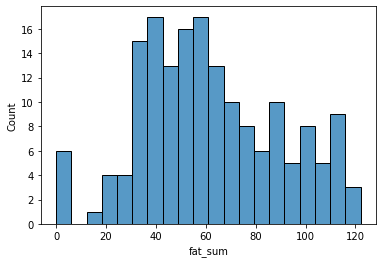

In [33]:
# fat intake distribution worldwide
fig1 = sns.histplot(x='fat_sum', data=df_macro, stat='count', bins=20)

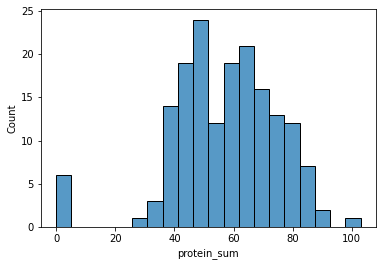

In [34]:
# protein intake distribution worldwide
fig2 = sns.histplot(x='protein_sum', data=df_macro, stat='count', bins=20)

In [35]:
# TODO: check if the histrograms look correct. right now 
# TODO: create carbs intake distribution worldwide

## Histogram of Worldwide Covid Distribution ##
* `x` : percentage of each case
* `y` : count of countries that fall under each bin

In [36]:
print('Total number of countries in the dataset: ', len(df_covid['country']))

Total number of countries in the dataset:  170


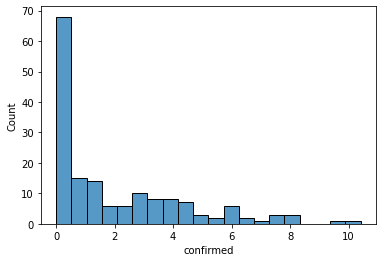

In [37]:
# covid confirmed cases distribution worldwide
fig3 = sns.histplot(x='confirmed', data=df_covid, stat='count', bins=20)

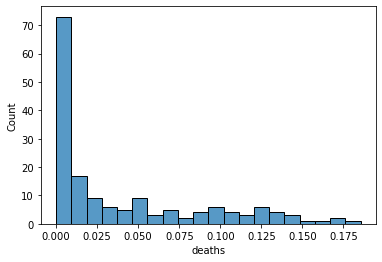

In [38]:
# covid deaths cases distribution worldwide
fig4 = sns.histplot(x='deaths', data=df_covid, stat='count', bins=20)

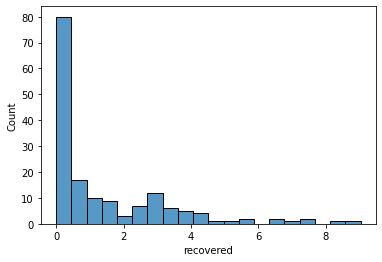

In [39]:
# covid recovered cases distribution worldwide
fig3 = sns.histplot(x='recovered', data=df_covid, stat='count', bins=20)

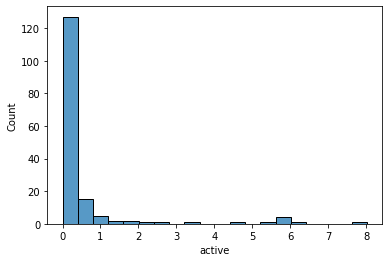

In [40]:
# covid active cases distribution worldwide
fig3 = sns.histplot(x='active', data=df_covid, stat='count', bins=20)

In [41]:
# TODO: regression + other analysis?

## Is there a correlation between macronutrient consumption and COVID rates in a country? ##

In [42]:
# combine macronutrient dataframe with COVID dataframe
macro_covid_combined_df = pd.concat([df_macro, df_covid], axis=1)
macro_covid_combined_df.head()

,country,fat_sum,protein_sum,country,confirmed,deaths,recovered,active,population
0,Afghanistan,22.34895,39.48570,Afghanistan,0.142134,0.006186,0.123374,0.012574,38928000.0
1,Albania,85.87720,87.26785,Albania,2.967301,0.050951,1.792636,1.123714,2838000.0
2,Algeria,58.17735,67.82430,Algeria,0.244897,0.006558,0.167572,0.070767,44357000.0
3,Angola,35.58385,39.49300,Angola,0.061687,0.001461,0.056808,0.003419,32522000.0
4,Antigua and Barbuda,65.04665,59.45120,Antigua and Barbuda,0.293878,0.007143,0.190816,0.095918,98000.0


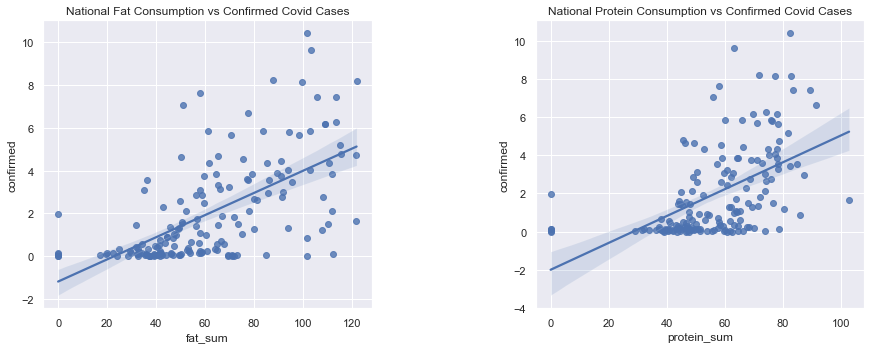

In [43]:
# generate scatterplots with a regression line to visualize relationship 
# between macronutrient consumption and confirmed COVID cases
sns.set()
fig, axes = plt.subplots(1,2)
sns.regplot(data = macro_covid_combined_df, x = 'fat_sum', y = 'confirmed', ax = axes[0])
axes[0].set_title('National Fat Consumption vs Confirmed Covid Cases')
sns.regplot(data = macro_covid_combined_df, x = 'protein_sum', y = 'confirmed', ax = axes[1])
axes[1].set_title('National Protein Consumption vs Confirmed Covid Cases')

# set spacing between the subplots
plt.subplots_adjust(left = 0.1, bottom = -0.1, right = 2.0, top=0.9, wspace = 0.5)

In [44]:
# Linear regression on fat consumption and covid cases
outcome_fat, predictors_fat = patsy.dmatrices('confirmed ~ fat_sum', macro_covid_combined_df)
mod_fat = sm.OLS(outcome_fat, predictors_fat)
res_fat = mod_fat.fit()
print(res_fat.summary())

                            OLS Regression Results                            
Dep. Variable:              confirmed   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     101.1
Date:                Thu, 19 May 2022   Prob (F-statistic):           8.77e-19
Time:                        23:27:38   Log-Likelihood:                -333.30
No. Observations:                 164   AIC:                             670.6
Df Residuals:                     162   BIC:                             676.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1851      0.350     -3.382      0.0

In [45]:
# Linear regression on protein consumption and covid cases
outcome_protein, predictors_protein = patsy.dmatrices('confirmed ~ protein_sum', macro_covid_combined_df)
mod_protein = sm.OLS(outcome_protein, predictors_protein)
res_protein = mod_protein.fit()
print(res_protein.summary())

                            OLS Regression Results                            
Dep. Variable:              confirmed   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     62.29
Date:                Thu, 19 May 2022   Prob (F-statistic):           4.20e-13
Time:                        23:27:46   Log-Likelihood:                -346.38
No. Observations:                 164   AIC:                             696.8
Df Residuals:                     162   BIC:                             703.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.0053      0.534     -3.756      

__Interpretation__

In both the scatterplots, we can observe a linear relationship between the two variables using the regression line.

Additionally, the results of the linear regression analysis suggest that there are statistically signficant relationships between fat consumption and COVID cases and protein consumption and COVID cases. We can see that the 95% confidence interval for both coefficients do not include 0.